#**Data Wrangling (Part 3) Los Angeles County Urban Trees**

**Summary**

The purpose of this notebook is to data clean median income, federal poverty levels, indices of environmental justice, and to analyze the data. The notebook shows the steps taken to prepare the raw dataset for exploratory data analysis and statistical analysis. A brief summary of the content of this notebook is below:

**Importing Data**

LA county data on median income, federal poverty levels, indices of enviromental justice (i.e. hazard proximity to sensitive uses, health risk and exposure, social and health vulnerability, and climate change vulnerability) were imported from https://geohub.lacity.org/search

**Cleaning Data**

**A. Median income data**

i. Removing rows with no median income data. 

ii. Removing data from median income data > $150K. These boundaries are in areas that have close access to natural forestry. 

iii. Cleaning location data to match with main dataset.

**B. Federal poverty data** 

i. Calculating 100% federal poverty level (FPL) and 200% FPL data from population data. 

ii. Cleaning location data to match with main dataset.

**C. Environmental justice data**

i. Cleaning location data to match with main dataset.


In [1]:
#This notebook is done google colab.

#Mounting your google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#Importing relevant packages
import pandas as pd
import numpy as np

!pip install geopandas
import geopandas as gpd

from shapely import wkt

import matplotlib.pyplot as plt
import seaborn as sns

!pip3 install contextily
import contextily as ctx

     |████████████████████████████████| 972kB 2.7MB/s 
     |████████████████████████████████| 6.5MB 13.8MB/s 
     |████████████████████████████████| 14.8MB 310kB/s 
     |████████████████████████████████| 18.3MB 2.4MB/s 


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
#Import LA county federal poverty dataset from download files from https://geohub.lacity.org/datasets/lacounty::population-and-poverty-by-census-tract
poverty_df = gpd.read_file("/content/drive/My Drive/Public Trees - Wes/poverty/Population_and_Poverty_by_Census_Tract.shp", encoding="utf-8")

#Select relevant columns for calculating federal poverty rates (FPL)
poverty_df = poverty_df[['tract','male','male18a','male18d','female','female18a','female18d','geometry','ShapeSTLen']]

#Calculating 100% FPL and 200% FPL
poverty_df["100FPL"] = ((poverty_df["male18a"] + poverty_df["female18a"])/(poverty_df["male"] + poverty_df["female"]))*100
poverty_df["200FPL"] = ((poverty_df["male18d"] + poverty_df["female18d"])/(poverty_df["male"] + poverty_df["female"]))*100

#keep relevant columns
poverty_df = poverty_df[['100FPL','200FPL','tract']]

#Creating an index column for merging later
poverty_df["Unnamed: 0"] = np.arange(len(poverty_df))

#Overview of dataframe
poverty_df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2344 entries, 0 to 2343
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   100FPL      2327 non-null   float64
 1   200FPL      2327 non-null   float64
 2   tract       2344 non-null   object 
 3   Unnamed: 0  2344 non-null   int64  
dtypes: float64(2), int64(1), object(1)
memory usage: 73.4+ KB


In [4]:
#Import LA county environmental justice scores dataset from download files from https://geohub.lacity.org/datasets/lacounty::ejsm-scores
ejsm_df = gpd.read_file("/content/drive/My Drive/Public Trees - Wes/EJSM/3add6368-e61a-4279-8cc3-ad1ccb0eaadf202041-1-180j648.ou0r.shp", encoding="utf-8")

#Function to clean cenus tract ID
def tract_ext(int1):
  int1 = str(int1)
  return int1[4:]

#Cleaning census tract ID
ejsm_df['tract'] = ejsm_df['Tract_1'].apply(tract_ext)

#Keeping relevant columns
ejsm_df = ejsm_df[['tract','CIscore','HazScore','HealthScor','SVscore','CCVscore']]

#Overview of dataframe
ejsm_df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2343 entries, 0 to 2342
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   tract       2343 non-null   object
 1   CIscore     2343 non-null   int64 
 2   HazScore    2343 non-null   int64 
 3   HealthScor  2343 non-null   int64 
 4   SVscore     2343 non-null   int64 
 5   CCVscore    2343 non-null   int64 
dtypes: int64(5), object(1)
memory usage: 110.0+ KB


In [5]:
#Import median income and trees density data
#Recall that the calculation was done in 5 parts, exported to 5 CSV files

trees_intersect = pd.DataFrame()
for i in range(1,6):
  path = f'/content/drive/My Drive/Public Trees - Wes/income{i}.csv'
  trees = pd.read_csv(path)
  trees_intersect = trees_intersect.append(trees)

#Using shapely.wkt sub-module to parse wkt format
trees_intersect['geometry'] = trees_intersect['geometry'].apply(wkt.loads)

#Converting to geopandas dataframe
trees_intersect = gpd.GeoDataFrame(trees_intersect, geometry='geometry')

#changing the Coordinate Reference System of this dataframe
trees_intersect.set_crs(epsg=4326 , inplace=True)
trees_intersect["geometry"] = trees_intersect["geometry"].to_crs("EPSG:3857")

#Overview of dataframe
trees_intersect.info()

##Viewing the first few columns of the dataset
trees_intersect.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 2344 entries, 0 to 343
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   Unnamed: 0  2344 non-null   int64   
 1   B19013e1    2344 non-null   int64   
 2   ShapeSTAre  2344 non-null   float64 
 3   ShapeSTLen  2344 non-null   float64 
 4   geometry    2344 non-null   geometry
 5   counts      2344 non-null   int64   
dtypes: float64(2), geometry(1), int64(3)
memory usage: 128.2 KB


,Unnamed: 0,B19013e1,ShapeSTAre,ShapeSTLen,geometry,counts
0,0,50732,4.025736e+09,353933.808192,"POLYGON ((-13098645.356 4103977.932, -13098645...",74
1,1,0,2.078690e+09,273188.863210,"POLYGON ((-13122411.059 4131804.394, -13122622...",0
2,2,75313,1.111802e+10,628603.531323,"POLYGON ((-13097322.292 4082265.425, -13097316...",201
3,3,63182,4.824002e+06,9050.008458,"POLYGON ((-13157879.783 4001593.671, -13157879...",719
4,4,65729,6.697031e+06,12308.315385,"POLYGON ((-13167759.055 3991612.896, -13167758...",87


In [6]:
#merging poverty_df and ejsm_df to trees_intersect:
trees_intersect = pd.merge(trees_intersect,poverty_df,on="Unnamed: 0")
trees_intersect = pd.merge(trees_intersect,ejsm_df,on="tract")

#Rename median_income column
trees_intersect = trees_intersect.rename(columns={'B19013e1': 'median_income'})

#Calculate boundary area
trees_intersect["area"] = trees_intersect["geometry"].area

#Calculate number of trees per area (density)
trees_intersect["density"] = trees_intersect["counts"] / (trees_intersect["area"])

#Dropping irrelevant columns
trees_intersect = trees_intersect.drop(columns=['Unnamed: 0','ShapeSTAre','ShapeSTLen'])

#Overview of dataframe
trees_intersect.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 2342 entries, 0 to 2341
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   median_income  2342 non-null   int64   
 1   geometry       2342 non-null   geometry
 2   counts         2342 non-null   int64   
 3   100FPL         2326 non-null   float64 
 4   200FPL         2326 non-null   float64 
 5   tract          2342 non-null   object  
 6   CIscore        2342 non-null   int64   
 7   HazScore       2342 non-null   int64   
 8   HealthScor     2342 non-null   int64   
 9   SVscore        2342 non-null   int64   
 10  CCVscore       2342 non-null   int64   
 11  area           2342 non-null   float64 
 12  density        2342 non-null   float64 
dtypes: float64(4), geometry(1), int64(7), object(1)
memory usage: 256.2+ KB


**Data Exploration**

Text(0.5, 1.0, '100% Federal Poverty Level (Los Angeles County)')

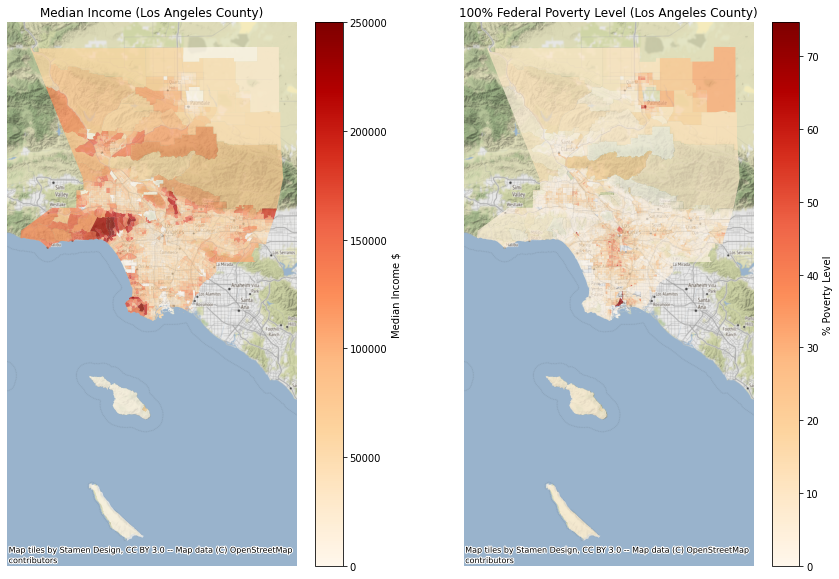

In [7]:
fig, (ax1, ax2) = plt.subplots(nrows= 1,ncols=2,figsize=(15,10))

#Setting geometry parameters
gdf = trees_intersect.to_crs(epsg=3857)

g1 = gdf.plot(figsize=(15, 15), ax=ax1, column='median_income',alpha=0.7, edgecolor='None',cmap='OrRd',legend=True,legend_kwds={'label': "Median Income $",'orientation': "vertical"})
g2 = gdf.plot(figsize=(15, 15), ax=ax2, column='100FPL',alpha=0.7, edgecolor='None',cmap='OrRd',legend=True,legend_kwds={'label': "% Poverty Level",'orientation': "vertical"})
ctx.add_basemap(ax1,zoom=10)
ctx.add_basemap(ax2,zoom=10)
ax1.set_axis_off()
ax2.set_axis_off()
ax1.set_title("Median Income (Los Angeles County)")
ax2.set_title("100% Federal Poverty Level (Los Angeles County)")

* Similar trend to between these 2 datasets (median income, 100% FPL)
* High median income areas such as Rolling Hills Estate, Beverly Glen, Hollywood Hills, Bel Air, have low poverty rates.
* Low median income areas are found close to downtown LA, have up higher poverty rates.

Text(0.5, 1.0, 'Climate Change Vulnerability')

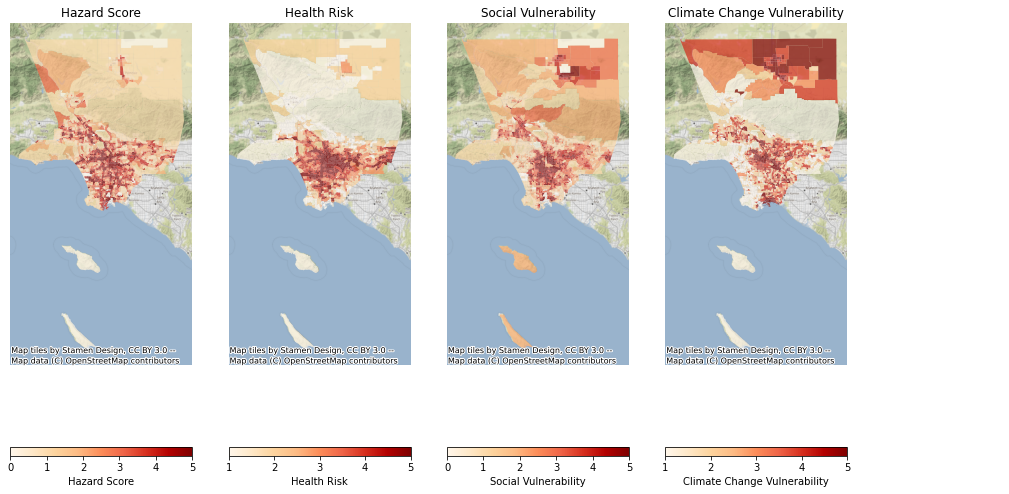

In [8]:
#Plotting Environmental Justice Indices by US Cenus Tract boundaries.
fig, ((ax1, ax2,ax3,ax4)) = plt.subplots(nrows= 1,ncols=4,figsize=(15,10))

g1 = gdf.plot(figsize=(15, 15), ax=ax1, column='HazScore',alpha=0.7, edgecolor='None',cmap='OrRd',legend=True,legend_kwds={'label': "Hazard Score",'orientation': "horizontal"})
g2 = gdf.plot(figsize=(15, 15), ax=ax2, column='HealthScor',alpha=0.7, edgecolor='None',cmap='OrRd',legend=True,legend_kwds={'label': "Health Risk",'orientation': "horizontal"})
g1 = gdf.plot(figsize=(15, 15), ax=ax3, column='SVscore',alpha=0.7, edgecolor='None',cmap='OrRd',legend=True,legend_kwds={'label': "Social Vulnerability",'orientation': "horizontal"})
g2 = gdf.plot(figsize=(15, 15), ax=ax4, column='CCVscore',alpha=0.7, edgecolor='None',cmap='OrRd',legend=True,legend_kwds={'label': "Climate Change Vulnerability",'orientation': "horizontal"})

ctx.add_basemap(ax1,zoom=10)
ctx.add_basemap(ax2,zoom=10)
ctx.add_basemap(ax3,zoom=10)
ctx.add_basemap(ax4,zoom=10)

ax1.set_axis_off()
ax2.set_axis_off()
ax3.set_axis_off()
ax4.set_axis_off()

ax1.set_title("Hazard Score")
ax2.set_title("Health Risk")
ax3.set_title("Social Vulnerability")
ax4.set_title("Climate Change Vulnerability")


* Explanation for the scores can be found here (https://planning.lacounty.gov/assets/img/gis/agol/Green_Zones_EJSM_Data_Sources.pdf).

* Similarly, all 4 indices for environmental justice shows high scores around DTLA area, with the exception of Climate Change score which is also high around the northen part of LA county.

In [9]:
#Filter dataset to include relevant values
trees_intersect = trees_intersect[trees_intersect["density"] > 0]
trees_intersect = trees_intersect[trees_intersect["100FPL"] > 0]
trees_intersect = trees_intersect[trees_intersect["200FPL"] > 0]

#Filtering away median income data > $150K. These boundaries are in areas that have close access to natural forestry.
trees_intersect = trees_intersect[trees_intersect["median_income"] > 0]
trees_intersect = trees_intersect[trees_intersect["median_income"] < 150000]

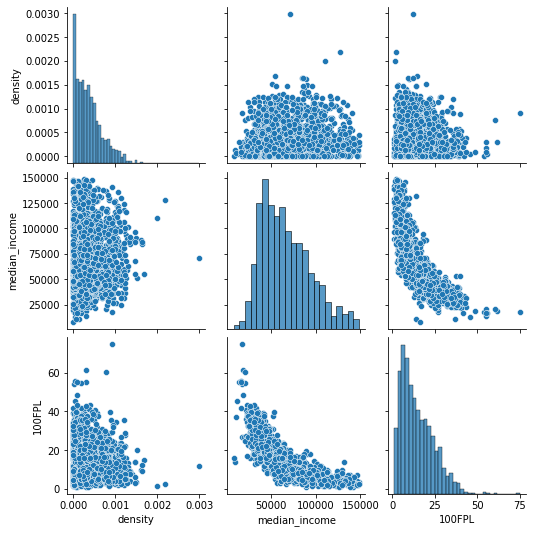

In [10]:
#Pairplot of tree density, median income and 100% federal poverty level (FPL) rates.
plotthis = trees_intersect[['density','median_income','100FPL']]
sns.pairplot(plotthis)

* Tree density data is heavily skewed to the right. (We could potentially transform it to a normal distribution before analysis)
* Possible positive association between median income and 100% FPL rates
* Possible negative association between tree densities and 100% FPL rates.

**Statistical Analysis**

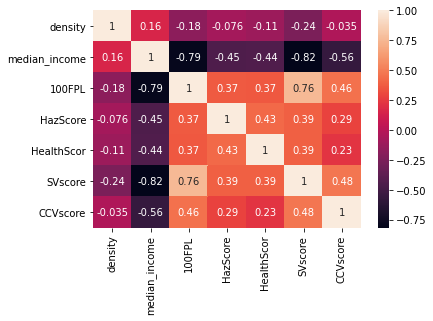

In [11]:
#Ploting correlation matrix of tree density, median income, 100% FPL and environmental justice indices.
matrix_df = pd.DataFrame(trees_intersect,columns=['density','median_income','100FPL','HazScore','HealthScor','SVscore','CCVscore'])
corrMatrix = matrix_df.corr(method="pearson")
sns.heatmap(corrMatrix, annot=True)
plt.show()

In [12]:
#Using scipy to calculate p-value for pearson correlation
from scipy import stats

variables = ['median_income','100FPL','HazScore','HealthScor','SVscore','CCVscore']
coeff = []
pvalue = []

for i in variables:
  corr_coeff, p_val = stats.pearsonr(trees_intersect['density'],trees_intersect[i])
  coeff.append(corr_coeff)
  pvalue.append(p_val)

#Storing the stats data in a pandas dataframe
stats_df = pd.DataFrame({
    "variable": variables,
    "coeff": coeff,
    "pvalue": pvalue
})

#Show dataframe
stats_df

,variable,coeff,pvalue
0,median_income,0.156088,1.455081e-11
1,100FPL,-0.176192,2.257440e-14
2,HazScore,-0.075877,1.086959e-03
3,HealthScor,-0.111197,1.621173e-06
4,SVscore,-0.243546,2.125489e-26
5,CCVscore,-0.034723,1.353526e-01


* Tree density is positively correlated with median income and this correlation is statisically significant (p < 0.01)
* Tree density is negatively correlated with poverty level, hazard score, health risk score, and social vulnerability score and these correlations are statistically significant (p < 0.01)
* Although tree density is negatively correlated with Climate Change Vulnerability score, it is not statistically significant. 